In [1]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
import gurobipy as gb
from keplergl import KeplerGl
from gtfs_functions import Feed
from sklearn.metrics.pairwise import manhattan_distances

In [3]:
logging.getLogger().setLevel(logging.WARNING)

## Loading data


In [4]:
NUM_ROUTES = 3
distance_matrix = pd.read_json("distance_matrix.json")

In [ ]:
# add depot to distance matrix
for i in range(NUM_ROUTES):
    distance_matrix.loc[i+1] = 0.0
    distance_matrix[i+1] = 0.0

distance_matrix

In [ ]:
np.nanmax(distance_matrix.to_numpy())

In [ ]:
distance_matrix.fillna(1e2, inplace=True)

In [ ]:
distance_matrix

In [ ]:
nodes = list(distance_matrix.index)
num_nodes = len(nodes)

# TSP - Bus Route Optimization

In [ ]:
vrp = gb.Model("Montreal Bus Routing")
vrp.Params.MIPGap = 0.3
vrp.Params.TimeLimit = 30
start_node_index = 68


# Decision variables
x = vrp.addVars(nodes, nodes, vtype=gb.GRB.BINARY, name="x")

u = vrp.addVars(nodes, vtype=gb.GRB.INTEGER, name="u", ub=num_nodes)

# Objective function
vrp.setObjective(
    gb.quicksum(distance_matrix.loc[i, j] * x[i, j] for i in nodes for j in nodes),
    gb.GRB.MINIMIZE,
)

# Constraints
vrp.addConstrs(
    (gb.quicksum(x[i, j] for j in nodes if j != i) == 1 for i in nodes),
    name="outgoing",
)

vrp.addConstrs(
    (gb.quicksum(x[j, i] for j in nodes if j != i) == 1 for i in nodes),
    name="ingoing",
)

vrp.addConstrs(
    (
        u[i] - u[j] + num_nodes * x[i, j] <= num_nodes - 1
        for i in nodes
        for j in nodes
        if i != j and i != nodes[start_node_index] and j != nodes[start_node_index]
    ),
    name="subtour_elimination",
)

vrp.addConstrs(
    (u[i] >= 2 for i in nodes if i != nodes[start_node_index]), name="lower bound for u"
)

vrp.addConstr(
    u[nodes[start_node_index]] == 1,
    name="start node index is 1",
)

vrp.optimize()

In [ ]:
nodes[start_node_index]

In [ ]:
print("Minimum distance: ", vrp.objVal)
print("Optimal path: ")
tour = []
for v in vrp.getVars():
    if v.varName.startswith("u"):
        tour.append(v)

for s in sorted(tour, key=lambda x: x.x):
    print(s.varName, s.x)

In [ ]:
# Distances
distances = []

for i in nodes:
    for j in nodes:
        if x[i, j].x == 1:
            distances.append(distance_matrix[i][j])

pd.Series(distances).describe()

In [ ]:
# Plotting the directed graph
G = nx.DiGraph()

for i in nodes:
    for j in nodes:
        if x[i, j].x == 1:
            G.add_edge(
                i, j, weight=distance_matrix[i][j], step=u[i].x, label=f"{i}-{j}"
            )

pos = nx.spring_layout(G)
steps = nx.get_edge_attributes(G, "step")

from pyvis.network import Network

net = Network(
    directed=True,
    notebook=True,
    select_menu=True,
    filter_menu=True,
    cdn_resources="remote",
    neighborhood_highlight=True,
)

net.from_nx(G)
net.show_buttons()


net.show("example.html")

In [ ]:
# convert tour into dictionary of steps and nodes

tour_dict = {}

for node in tour:
    node_name = node.varName

    node_name = re.sub(r"[u\[\]]", "", node_name)
    tour_dict[node.x] = int(node_name)

tour_df = (
    pd.DataFrame.from_dict(tour_dict, orient="index", columns=["node"])
    .sort_index()
    .reset_index()
    .rename(columns={"index": "step"})
)

tour_df = tour_df.merge(stops, left_on="node", right_on="stop_code", how="left")

tour_df["stop_lat"] = tour_df["stop_lat"].fillna(45.5376881)
tour_df["stop_lon"] = tour_df["stop_lon"].fillna(-73.5705049)
tour_df["stop_name"] = tour_df["stop_name"].fillna("Depot")

tour_df["geometry"] = tour_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

tour_df = gpd.GeoDataFrame(tour_df, geometry="geometry")

tour_df

In [ ]:
depot_steps = tour_df[tour_df["stop_name"] == "Depot"].index.tolist()

tours = []

for i in range(len(depot_steps) - 1):
    tours.append(tour_df.iloc[depot_steps[i] : depot_steps[i + 1] + 1])

tours.append(tour_df.iloc[depot_steps[-1] :])

In [ ]:
tour_lines = []

for i, tour_ in enumerate(tours):
    tour_lines.append({"route_id": i, "geometry": LineString(tour_.geometry.tolist())})


tour_lines = gpd.GeoDataFrame.from_dict(tour_lines, geometry="geometry")

tour_lines

In [ ]:
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [
                {
                    "dataId": ["routes"],
                    "id": "cc52bgyolv",
                    "name": ["route_id"],
                    "type": "range",
                    "value": [0, 0.73],
                    "enlarged": False,
                    "plotType": "histogram",
                    "animationWindow": "free",
                    "yAxis": None,
                    "speed": 1,
                }
            ],
            "layers": [
                {
                    "id": "w9xelah",
                    "type": "point",
                    "config": {
                        "dataId": "stops_in_trip",
                        "label": "stop",
                        "color": [221, 178, 124],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {
                            "lat": "stop_lat",
                            "lng": "stop_lon",
                            "altitude": "step",
                        },
                        "isVisible": True,
                        "visConfig": {
                            "radius": 10,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "outline": False,
                            "thickness": 2,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "radiusRange": [0, 50],
                            "filled": True,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": {"name": "step", "type": "integer"},
                        "colorScale": "quantile",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                    },
                },
                {
                    "id": "ez5bm5",
                    "type": "geojson",
                    "config": {
                        "dataId": "routes",
                        "label": "routes",
                        "color": [30, 150, 190],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {"geojson": "geometry"},
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "strokeOpacity": 0.8,
                            "thickness": 1,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Global Warming",
                                "type": "sequential",
                                "category": "Uber",
                                "colors": [
                                    "#5A1846",
                                    "#900C3F",
                                    "#C70039",
                                    "#E3611C",
                                    "#F1920E",
                                    "#FFC300",
                                ],
                            },
                            "strokeColorRange": {
                                "name": "ColorBrewer Paired-5",
                                "type": "qualitative",
                                "category": "ColorBrewer",
                                "colors": [
                                    "#a6cee3",
                                    "#1f78b4",
                                    "#b2df8a",
                                    "#33a02c",
                                    "#fb9a99",
                                ],
                            },
                            "radius": 10,
                            "sizeRange": [0, 10],
                            "radiusRange": [0, 50],
                            "heightRange": [0, 500],
                            "elevationScale": 5,
                            "enableElevationZoomFactor": True,
                            "stroked": True,
                            "filled": False,
                            "enable3d": False,
                            "wireframe": False,
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": None,
                        "colorScale": "quantile",
                        "strokeColorField": {"name": "route_id", "type": "integer"},
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                        "heightField": None,
                        "heightScale": "linear",
                        "radiusField": None,
                        "radiusScale": "linear",
                    },
                },
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "stops_in_trip": [
                            {"name": "stop_name", "format": None},
                            {"name": "step", "format": None},
                        ],
                        "routes": [{"name": "route_id", "format": None}],
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": True,
                },
                "brush": {"size": 0.5, "enabled": False},
                "geocoder": {"enabled": False},
                "coordinate": {"enabled": False},
            },
            "layerBlending": "normal",
            "splitMaps": [],
            "animationConfig": {"currentTime": None, "speed": 1},
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 45.59783403161273,
            "longitude": -73.62435981591366,
            "pitch": 0,
            "zoom": 10,
            "isSplit": False,
        },
        "mapStyle": {
            "styleType": "light",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False,
            },
            "threeDBuildingColor": [
                218.82023004728686,
                223.47597962276103,
                223.47597962276103,
            ],
            "mapStyles": {},
        },
    },
}

In [ ]:
map = KeplerGl(height=700, config=config)

map.add_data(
    data=tour_df[["stop_lat", "stop_lon", "stop_name", "step"]],
    name="stops_in_trip",
)

map.add_data(
    data=tour_lines[['route_id', 'geometry']],
    name="routes",
)

map

# VRP - Number of buses

In [5]:
# feed = Feed("./STM GTFS/gtfs_stm.zip", busiest_date=False)

In [6]:
# routes = feed.routes
# trips = feed.trips
# stops = feed.stops
# stop_times = feed.stop_times
# shapes = feed.shapes
# segments = feed.segments

In [7]:
segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[['route_id', 'start_stop_id', 'end_stop_id']] = segments[['route_id', 'start_stop_id', 'end_stop_id']].astype(str)

In [8]:
def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route

### Get stops on route

In [9]:
routes = ["35", "61", "15", "51", "18", "107", "144", "74", "12"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

In [10]:
stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()
print(f"Number of total stops in routes: {len(stops_df)}")
stops_df.head()

Number of total stops in routes: 270


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding,geometry
422,61743,61743,Notre-Dame / Guy,45.489959,-73.567233,https://www.stm.info/fr/recherche#stq=61743,0,NaN,1,POINT (-73.567233 45.489959)
423,61744,61744,de la Montagne / Ottawa,45.492014,-73.561145,https://www.stm.info/fr/recherche#stq=61744,0,NaN,1,POINT (-73.561145 45.492014)
424,61745,61745,de la Montagne / du Square-Gallery,45.491756,-73.558727,https://www.stm.info/fr/recherche#stq=61745,0,NaN,1,POINT (-73.558727 45.491756)
438,61765,61765,Wellington / Prince,45.496656,-73.555554,https://www.stm.info/fr/recherche#stq=61765,0,NaN,1,POINT (-73.555554 45.496656)
591,62063,62063,Notre-Dame / Bérard,45.480191,-73.579727,https://www.stm.info/fr/recherche#stq=62063,0,NaN,1,POINT (-73.579727 45.480191)


## Visualize stops on a map

In [11]:
stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
422,61743,61743,Notre-Dame / Guy,45.489959,-73.567233,https://www.stm.info/fr/recherche#stq=61743,POINT (-73.56723 45.48996)
423,61744,61744,de la Montagne / Ottawa,45.492014,-73.561145,https://www.stm.info/fr/recherche#stq=61744,POINT (-73.56114 45.49201)
424,61745,61745,de la Montagne / du Square-Gallery,45.491756,-73.558727,https://www.stm.info/fr/recherche#stq=61745,POINT (-73.55873 45.49176)
438,61765,61765,Wellington / Prince,45.496656,-73.555554,https://www.stm.info/fr/recherche#stq=61765,POINT (-73.55555 45.49666)
591,62063,62063,Notre-Dame / Bérard,45.480191,-73.579727,https://www.stm.info/fr/recherche#stq=62063,POINT (-73.57973 45.48019)


In [12]:
random_stops_df_gpd = stops_df_gpd.sample(frac=0.2, random_state=421)

random_stops_df_gpd.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
423,61744,61744,de la Montagne / Ottawa,45.492014,-73.561145,https://www.stm.info/fr/recherche#stq=61744,POINT (-73.56114 45.49201)
2933,52517,52517,Station Place-des-Arts (Président-Kennedy / De...,45.507283,-73.569604,https://www.stm.info/fr/recherche#stq=52517,POINT (-73.56960 45.50728)
2931,52515,52515,Beaubien / de l'Assomption,45.576121,-73.567835,https://www.stm.info/fr/recherche#stq=52515,POINT (-73.56784 45.57612)
7030,56629,56629,Wellington / Rielle,45.459863,-73.567201,https://www.stm.info/fr/recherche#stq=56629,POINT (-73.56720 45.45986)
2823,52399,52399,Sainte-Catherine / Peel,45.499893,-73.572949,https://www.stm.info/fr/recherche#stq=52399,POINT (-73.57295 45.49989)


In [13]:
# Add a depot stop to the random stops dataframe in the beginning
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

random_stops_df_gpd

,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,61744,de la Montagne / Ottawa,45.492014,-73.561145,61744.0,POINT (-73.561145 45.492014),https://www.stm.info/fr/recherche#stq=61744
2,52517,Station Place-des-Arts (Président-Kennedy / De...,45.507283,-73.569604,52517.0,POINT (-73.569604 45.507283),https://www.stm.info/fr/recherche#stq=52517
3,52515,Beaubien / de l'Assomption,45.576121,-73.567835,52515.0,POINT (-73.567835 45.576121),https://www.stm.info/fr/recherche#stq=52515
4,56629,Wellington / Rielle,45.459863,-73.567201,56629.0,POINT (-73.567201 45.459863),https://www.stm.info/fr/recherche#stq=56629
5,52399,Sainte-Catherine / Peel,45.499893,-73.572949,52399.0,POINT (-73.572949 45.499893),https://www.stm.info/fr/recherche#stq=52399
6,56627,Wellington / 1re Avenue,45.458319,-73.567345,56627.0,POINT (-73.567345 45.458319),https://www.stm.info/fr/recherche#stq=56627
7,51214,Édouard-Montpetit / McKenna,45.501108,-73.620699,51214.0,POINT (-73.620699 45.501108),https://www.stm.info/fr/recherche#stq=51214
8,54136,Beaubien / 1re Avenue,45.550208,-73.590383,54136.0,POINT (-73.590383 45.550208),https://www.stm.info/fr/recherche#stq=54136
9,56584,de Verdun / 5e Avenue,45.456174,-73.571866,56584.0,POINT (-73.571866 45.456174),https://www.stm.info/fr/recherche#stq=56584


### Calculate Manhattan distance between stops

In [14]:
distance_matrix = pd.DataFrame(
    manhattan_distances(random_stops_df_gpd[["stop_lat", "stop_lon"]].values),
    index=random_stops_df_gpd["stop_id"],
    columns=random_stops_df_gpd["stop_id"],
)

display(distance_matrix.head())

stop_id,0,61744,52517,52515,56629,52399,56627,51214,54136,56584,...,52364,50799,56184,51805,54638,52186,52197,52887,60748,54398
stop_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.020819,0.002909,0.072555,0.046914,0.008787,0.048314,0.055322,0.066613,0.051423,...,0.016328,0.101219,0.049269,0.066435,0.108853,0.068495,0.021350,0.037175,0.061607,0.068758
61744,0.020819,0.000000,0.023728,0.090797,0.038207,0.019683,0.039895,0.068648,0.087432,0.046561,...,0.037147,0.096357,0.070088,0.087254,0.113715,0.089314,0.019834,0.016356,0.040788,0.089577
52517,0.002909,0.023728,0.000000,0.070607,0.049823,0.010735,0.051223,0.057270,0.063704,0.053371,...,0.013419,0.103167,0.046360,0.063526,0.106905,0.065586,0.023298,0.040084,0.064516,0.065849
52515,0.072555,0.090797,0.070607,0.000000,0.116892,0.081342,0.118292,0.127877,0.048461,0.123978,...,0.065106,0.173774,0.110499,0.051031,0.036298,0.021147,0.093905,0.107153,0.131585,0.087982
56629,0.046914,0.038207,0.049823,0.116892,0.000000,0.045778,0.001688,0.094743,0.113527,0.008354,...,0.063242,0.085734,0.096183,0.113349,0.151922,0.115409,0.045929,0.026069,0.039595,0.115672


In [15]:
stop_map = KeplerGl(height=700)

stop_map.add_data(
    data=random_stops_df_gpd[["stop_lat", "stop_lon", "stop_name", "stop_id"]],
    name="stops",
)

stop_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'stops': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

## Using Gurobi to solve the VRP - no capacity constraints

In [ ]:
# --------------------------------------------------------------------------------
# Paramters
distance_matrix_model = distance_matrix

stops = list(distance_matrix_model.index)
num_stops = len(stops)

num_buses = 5

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 300

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    num_buses,
    vtype=gb.GRB.INTEGER,
    lb=0,
    ub=num_stops,
    name=(f"Step for stop {i} (Bus {k+1})" for i in stops for k in range(num_buses)),
)

# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Each stop is visited once by one vehicle only
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for j in stops if j != i for k in range(num_buses)) == 1
        for i in stops[1:]
    ),
    name="outgoing",
)

model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops if i != j for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="incoming",
)

# Each vehicle leaves the depot and returns to the depot
model.addConstrs(
    (
        gb.quicksum(x[stops[0], j, k] for j in stops if j != stops[0]) == 1
        for k in range(num_buses)
    ),
    name="Vehicle leaves depot",
)

model.addConstrs(
    (
        gb.quicksum(x[i, stops[0], k] for i in stops if i != stops[0]) == 1
        for k in range(num_buses)
    ),
    name="Vehicle returns to depot",
)

# Flow conservation (routes are continuous)
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops if j != i)
        - gb.quicksum(x[i, j, k] for j in stops if j != i)
        == 0
        for i in stops[1:]
        for k in range(num_buses)
    ),
    name="Flow conservation",
)

# Subtour elimination
model.addConstrs(
    (
        u[i, k] - u[j, k] + num_stops * x[i, j, k] <= num_stops - 1
        for i in stops
        for j in stops
        for k in range(num_buses)
        if i != j and i != stops[0] and j != stops[0]
    ),
    name="Subtour elimination",
)

model.addConstrs(
    (u[stops[0], k] == 0 for k in range(num_buses)), name="Start node index is 0 (depot) for all buses"
)

In [ ]:
# Optimize
model.update()
model.optimize()

## Using Gurobi to solve the VRP - capacity constraints

In [107]:
import osmnx as ox

map_graph = ox.graph_from_place("Montreal, Canada", network_type="drive")
# map_graph = ox.project_graph(map_graph)

map_graph = ox.add_edge_speeds(map_graph)
map_graph = ox.add_edge_travel_times(map_graph)

KeyboardInterrupt: 

In [ ]:
def get_nearest_node(G, point1, point2):
    return (
        ox.utils_graph.route_to_gdf(
            G,
            ox.shortest_path(
                G,
                ox.nearest_nodes(G, X=point1.x, Y=point2.y),
                ox.nearest_nodes(G, X=point1.x, Y=point2.y),
                weight="length",
            ),
        )["length"].sum()
        / 1000
    )

In [ ]:
# get distance between all points in random_stops_df_gpd using osmnx

get_nearest_node(
    map_graph,
    random_stops_df_gpd.iloc[0].geometry,
    random_stops_df_gpd.iloc[1].geometry,
)

ValueError: graph contains no edges

In [38]:
# --------------------------------------------------------------------------------
# Paramters
g = np.random.default_rng(420)

distance_matrix_model = distance_matrix

stops = list(distance_matrix_model.index)
num_stops = len(stops)

demand_stops = {stop: 7 for stop in stops}
demand_stops[stops[0]] = 0  # Depot has no demand

num_buses = 5
BUS_CAPACITY = 100

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 120

# display(distance_matrix_model)

# --------------------------------------------------------------------------------
# Decision variables
x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (Bus {k+1})"
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.CONTINUOUS,
    name=(f"Step for stop {i}" for i in stops),
)


# --------------------------------------------------------------------------------
# Objective function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# --------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) == 1 for k in range(num_buses)),
    name="Every vehicle leaves the depot",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand_stops[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# Subtour elimination constraint
model.addConstrs(
    (
        u[j] - u[i] >= demand_stops[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand_stops[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# model.addConstr(
#     u[stops[0]] == 0,
#     name="Start node index is 0 (depot)",
# )

# No same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Optimize
model.update()
model.optimize()

Set parameter MIPGap to value 0.25
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 12058 rows, 12155 columns and 82408 nonzeros
Model fingerprint: 0x4fdc3542
Variable types: 55 continuous, 12100 integer (12100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 328 rows and 221 columns
Presolve time: 0.11s
Presolved: 11730 rows, 11934 columns, 81216 nonzeros
Variable types: 54 continuous, 11880 integer (11880 binary)

Root relaxation: objective 4.588120e-01, 326 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\iostream.py", line 608, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


H 2137  1927                       0.9072250    0.58830  35.2%  29.8   43s
H 2138  1832                       0.9018550    0.58830  34.8%  29.8   44s
  2139  1833    0.71258  122  132    0.90185    0.58830  34.8%  29.8   45s
H 2140  1741                       0.8959010    0.58830  34.3%  29.8   47s


### Visualize as network graphs and check cumulative load

In [34]:
print(f"Optimal objective: {model.objVal}")

# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:
        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

bus_path_df

Optimal objective: 0.9471925999999797


,start_stop,end_stop,distance,bus
0,0,56715,0.040152,0
1,56629,61743,0.030128,0
2,56627,56629,0.001688,0
3,56584,56627,0.006666,0
4,56673,60748,0.018714,0
5,56580,56584,0.004127,0
6,56693,56580,0.005136,0
7,61743,0,0.016786,0
8,56715,56673,0.015243,0
9,62074,56693,0.013992,0


In [35]:
def construct_paths(df):
    # Create a dictionary to hold paths for each bus
    paths = {}

    # Group the dataframe by bus
    grouped = df.groupby("bus")

    # Iterate over each bus group
    for bus, group in grouped:
        # Sort the group by the sequence of stops
        sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
            drop=True
        )
        path = ["0"]  # Initialize the path with the depot

        # Start with the first stop after the depot
        current_stop = sorted_group.loc[
            sorted_group["start_stop"] == "0", "end_stop"
        ].values[0]
        path.append(current_stop)

        # Follow the chain of stops until we return to the depot
        while True:
            # Find the next stop where the current stop is the start stop
            next_stop = sorted_group.loc[
                sorted_group["start_stop"] == current_stop, "end_stop"
            ].values
            if not next_stop:
                break  # If there is no next stop, we've completed the path
            next_stop = next_stop[0]

            # Add the next stop to the path and set it as the current stop
            if next_stop == "0":
                break  # If the next stop is the depot, we've completed the path
            path.append(next_stop)
            current_stop = next_stop

        # Store the path for this bus
        paths[bus] = path

    return paths


# Use the function to construct paths
paths = construct_paths(bus_path_df)

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)

In [36]:
bus_path_df["demand"] = bus_path_df["end_stop"].map(demand_stops)

bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

bus_path_df

,start_stop,end_stop,distance,bus,step,stop_id,stop_name,geometry,demand,step_demand
0,0,56715,0.040152,0,0,56715,Wellington / Regina,POINT (-73.566504 45.467322),7,7
1,56715,56673,0.015243,0,1,56673,du Golf / William-Paul,POINT (-73.55252 45.466063),7,14
2,56673,60748,0.018714,0,2,60748,Campus Bell (de la Pointe-Nord / J.-Le Ber),POINT (-73.540057 45.472314),7,21
3,60748,56661,0.017146,0,3,56661,de l'Île-des-Soeurs / Berlioz,POINT (-73.544266 45.459377),7,28
4,56661,56663,0.004232,0,4,56663,de l'Île-des-Soeurs / Darwin,POINT (-73.543031 45.45638),7,35
5,56663,60694,0.012749,0,5,60694,de la Pointe-Sud / des Sommets,POINT (-73.549835 45.450435),7,42
6,60694,62074,0.011563,0,6,62074,André-Prévost / Claude-Vivier,POINT (-73.558688 45.447725),7,49
7,62074,56693,0.013992,0,7,56693,de Verdun / Brault,POINT (-73.572641 45.447686),7,56
8,56693,56580,0.005136,0,8,56580,de Verdun / Woodland,POINT (-73.572208 45.452389),7,63
9,56580,56584,0.004127,0,9,56584,de Verdun / 5e Avenue,POINT (-73.571866 45.456174),7,70


Bus 0:


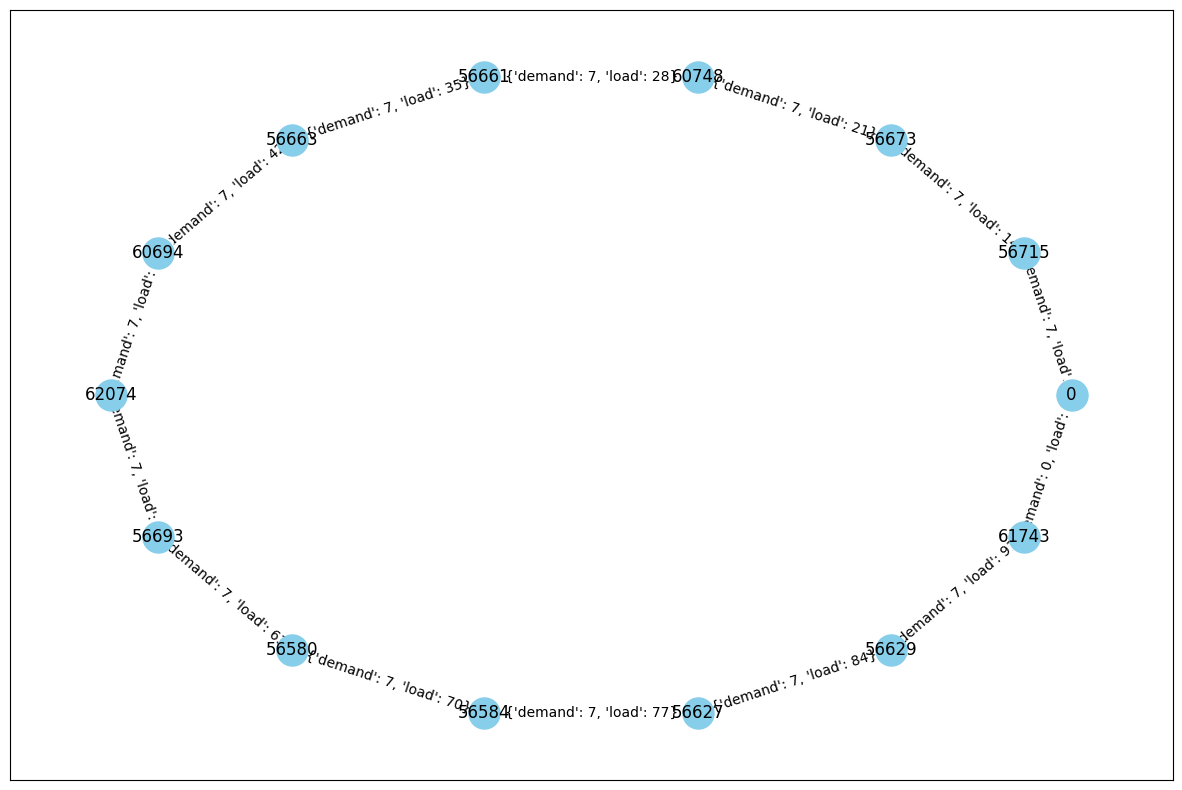



Bus 1:


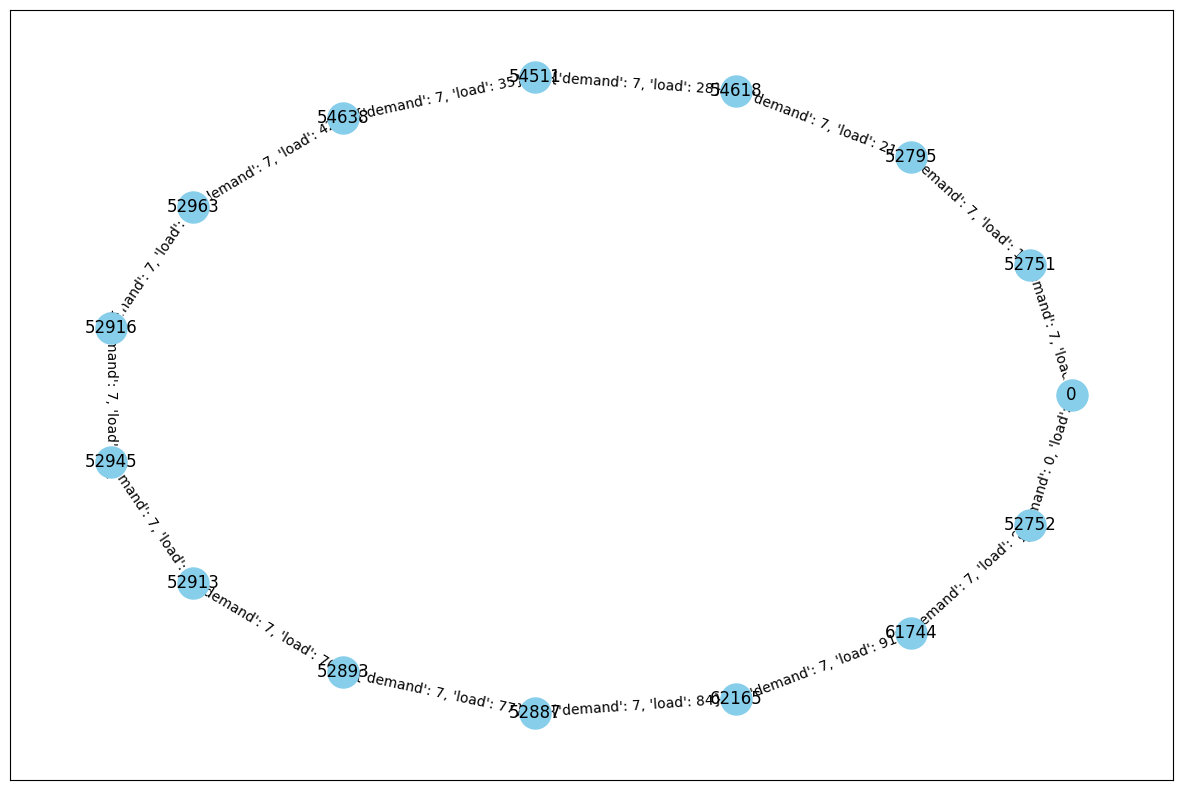



Bus 2:


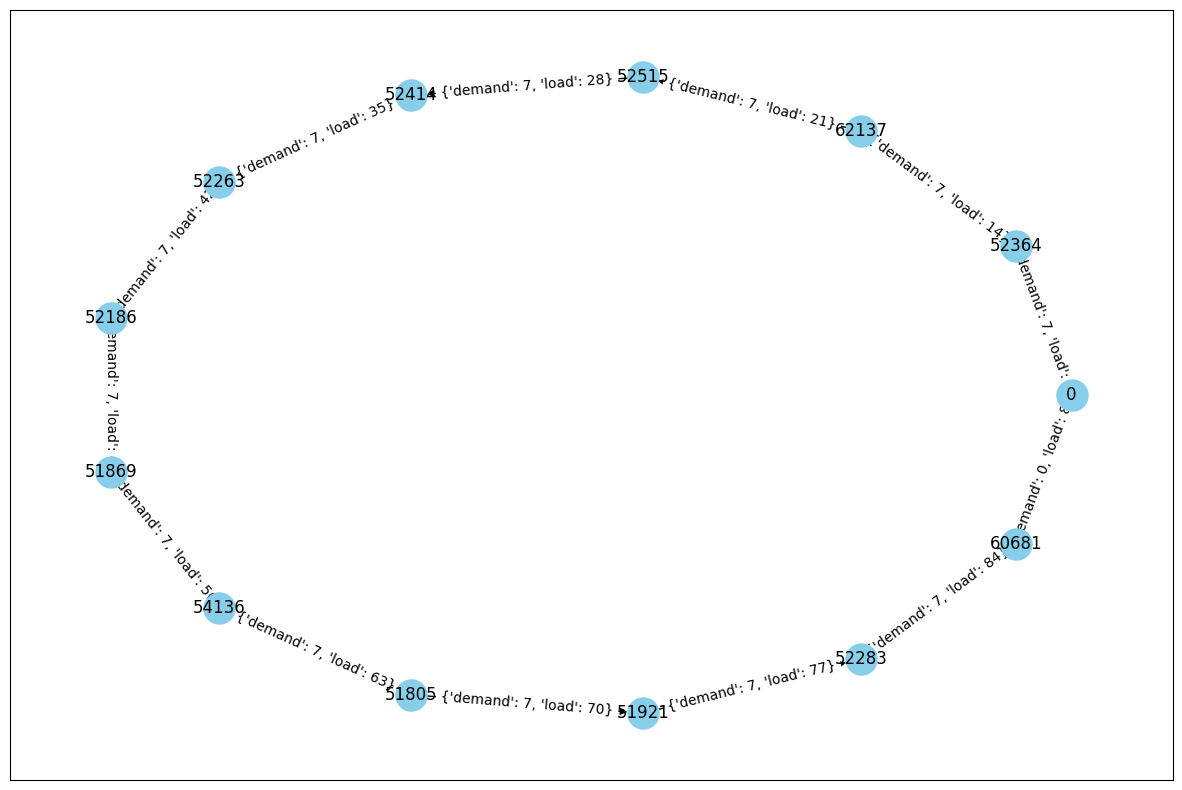



Bus 3:


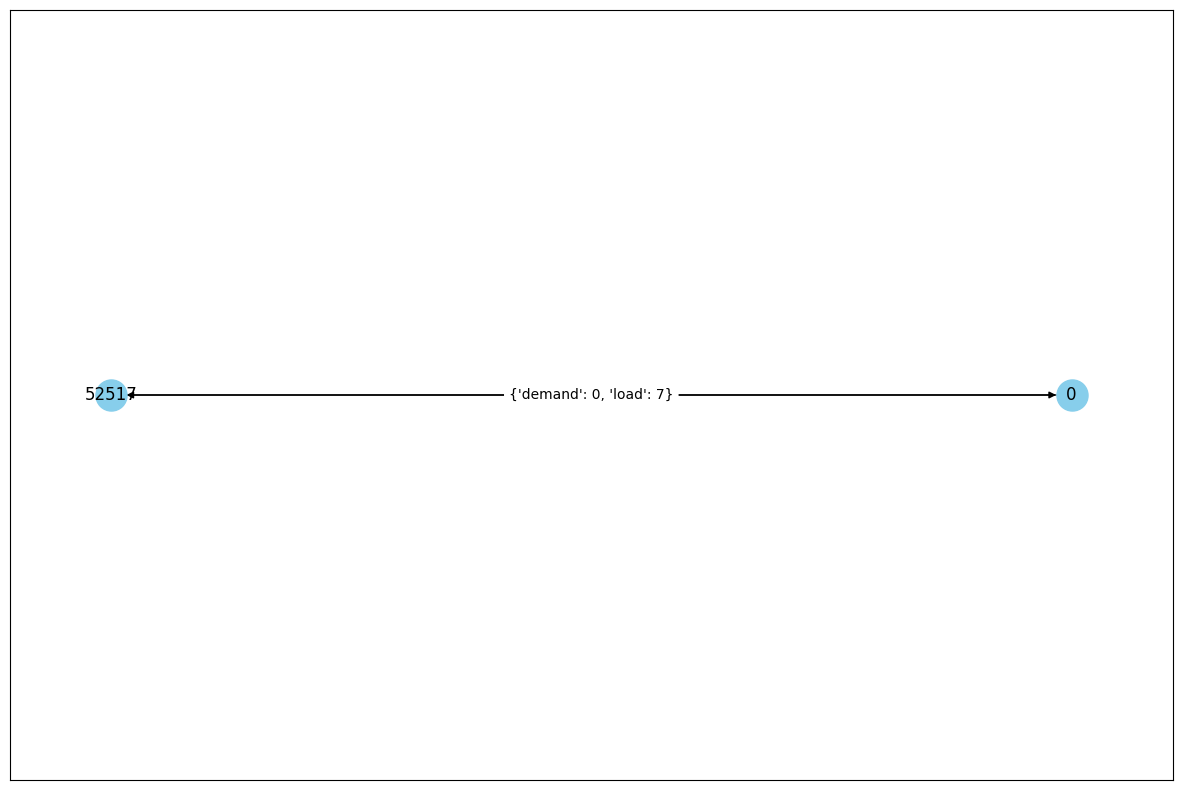



Bus 4:


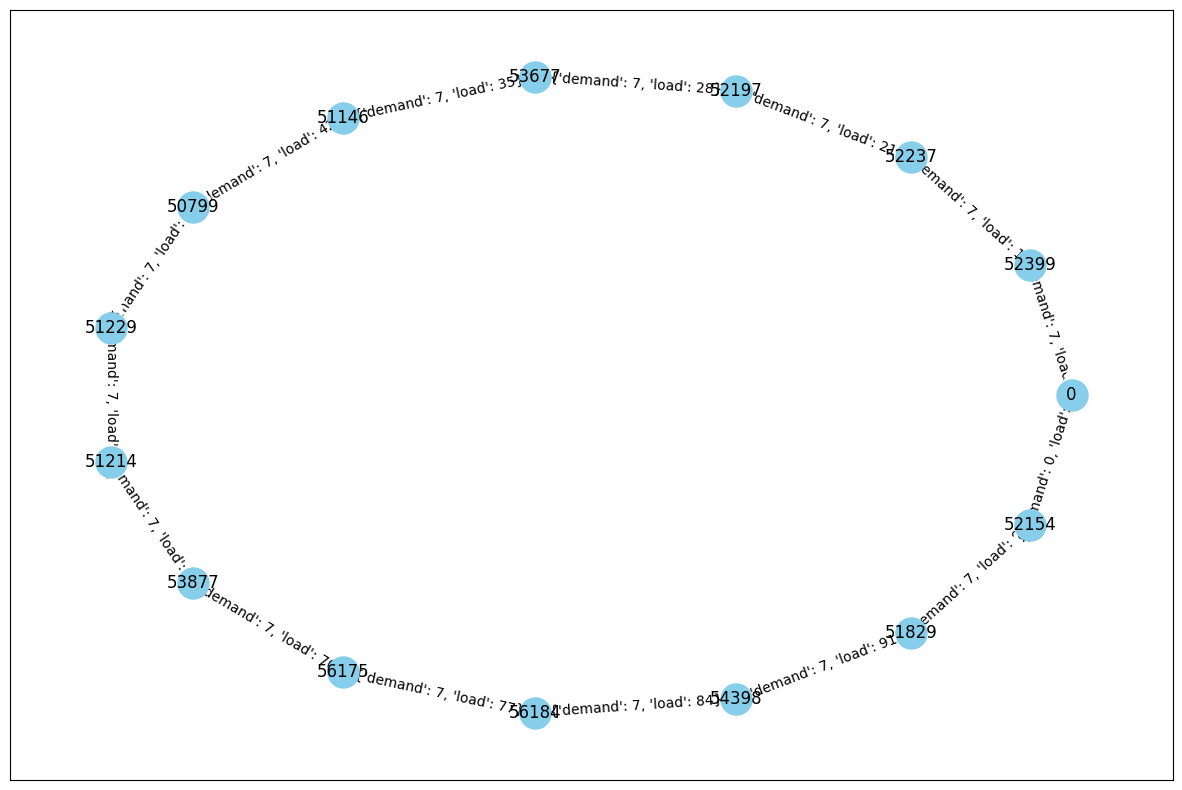

In [37]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(15, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={'demand': segment.demand, 'load': segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    # nx.draw_networkx_edge_labels(g, pos, edge_labels=nx.get_edge_attributes(g, "load"))
    nx.draw_networkx_edge_labels(g, pos, edge_labels=nx.get_edge_attributes(g, "demands"))

    plt.show()

    print("\n")

### Visualize routes to be taken by buses on a map

In [28]:
def print_optimal_paths(model, num_buses, stops):
    routes = {}

    print("Minimum distance: ", model.objVal)
    print("Optimal path for each bus: ")

    for k in range(num_buses):
        print(f"Bus {k+1}:")

        # Initialize with the depot as the starting point
        current_stop = stops[0]
        next_stop = None
        route = [current_stop]  # Start with the depot

        # Follow the path for the current bus
        while next_stop != stops[0]:
            for j in stops:
                if j != current_stop and x[current_stop, j, k].x > 0.5:
                    next_stop = j
                    route.append(next_stop)
                    current_stop = next_stop
                    break
            else:
                # If no next stop is found and we are not at the depot, it indicates an issue
                if current_stop != stops[0]:
                    print(
                        "Error: No valid next stop found. Check the model constraints."
                    )
                break

        routes[k] = route
        print(" -> ".join(map(str, route)))

    return routes

In [29]:
optimal_routes = print_optimal_paths(model, num_buses, stops)

Minimum distance:  0.9471925999999797
Optimal path for each bus: 
Bus 1:
0 -> 56715 -> 56673 -> 60748 -> 56661 -> 56663 -> 60694 -> 62074 -> 56693 -> 56580 -> 56584 -> 56627 -> 56629 -> 61743 -> 0
Bus 2:
0 -> 52751 -> 52795 -> 54618 -> 54511 -> 54638 -> 52963 -> 52916 -> 52945 -> 52913 -> 52893 -> 52887 -> 62165 -> 61744 -> 52752 -> 0
Bus 3:
0 -> 52364 -> 62137 -> 52515 -> 52414 -> 52263 -> 52186 -> 51869 -> 54136 -> 51805 -> 51921 -> 52283 -> 60681 -> 0
Bus 4:
0 -> 52517 -> 0
Bus 5:
0 -> 52399 -> 52237 -> 52197 -> 53677 -> 51146 -> 50799 -> 51229 -> 51214 -> 53877 -> 56175 -> 56184 -> 54398 -> 51829 -> 52154 -> 0


In [30]:
# For each optimal route, generate a GeoDataFrame with the stops and the route


def get_optimal_route_gdf(optimal_routes, stops_df_gpd):
    routes_gdf = {}

    for k, route in optimal_routes.items():
        # Add stops as GeoDataFrame with steps as index of route
        for step, stop in enumerate(route):
            stop_gdf = stops_df_gpd[stops_df_gpd["stop_id"] == stop]
            stop_gdf["step"] = step
            routes_gdf[k] = routes_gdf.get(k, pd.DataFrame()).append(stop_gdf)

    return routes_gdf


routes_gdf = get_optimal_route_gdf(optimal_routes, random_stops_df_gpd)

# add linestring of each point to the next point in the route


def get_route_lines(routes_gdf):
    route_lines = {}

    for k, route in routes_gdf.items():
        route_lines[k] = {
            "route_id": k,
            "geometry": LineString(route.geometry.tolist()),
        }

    return route_lines


route_lines = gpd.GeoDataFrame(
    pd.DataFrame(get_route_lines(routes_gdf)).T.reset_index(drop=True),
    geometry="geometry",
)

In [31]:
%run route_map_config.py

In [32]:
route_map = KeplerGl(height=900, config=config)

route_map.add_data(
    data=route_lines[["route_id", "geometry"]],
    name="routes",
)

for k, route in routes_gdf.items():
    route_map.add_data(
        data=route[["stop_lat", "stop_lon", "stop_id", "stop_name", "step"]],
        name=f"stops_in_trip_{k}",
    )

route_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'dw3m2pu', 'type': …